In [45]:
import pandas as pd
import numpy as np
np.random.seed(0)
import random

import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPool2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from sklearn.model_selection import learning_curve, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [46]:
# Reading the data
train = pd.read_csv('./digit-recognizer/train.csv')
test = pd.read_csv('./digit-recognizer/test.csv')

X_train = train.drop(labels=[ "label" ], axis=1)
y_train = train['label']

X_test = test

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


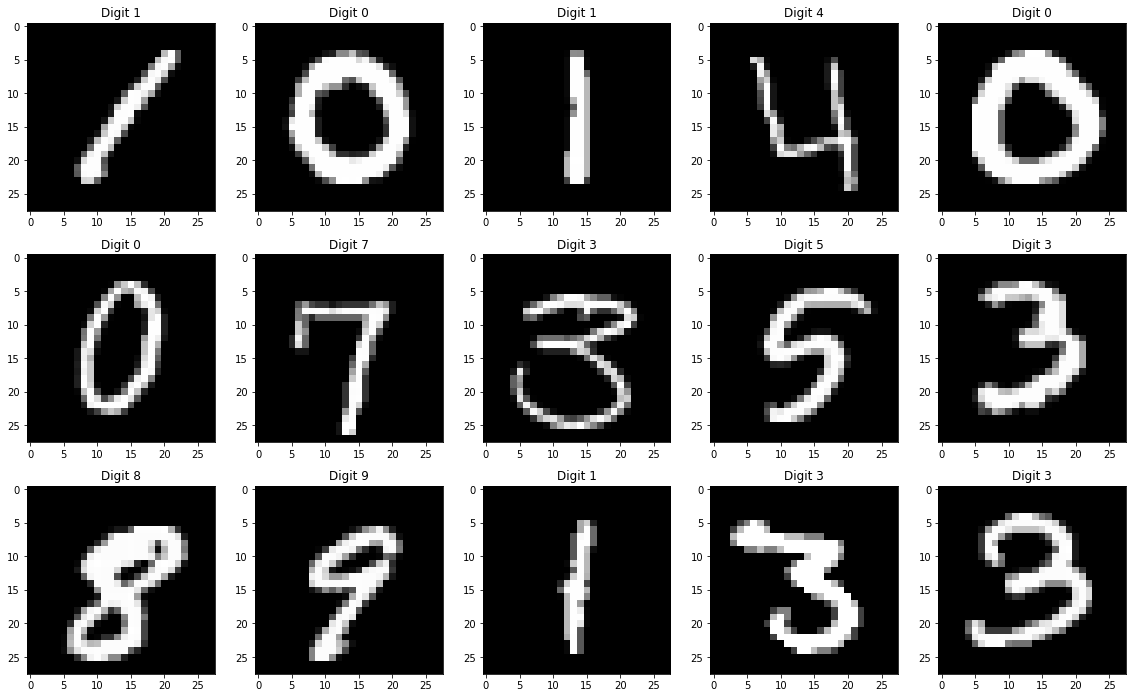

In [47]:
X_train_plot = X_train.values.reshape(-1, 28, 28)

def Show_example_digits(mono = 'gray'):
    fig = plt.figure(figsize=(16,16))
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X_train_plot[i], cmap=mono)
        plt.title("Digit {}".format(y_train[i]))

    plt.tight_layout()

Show_example_digits()

In [49]:
# Function return digit in grayscale
def plot_digit(digit, dem= 28, font_size = 12):
    max_ax = font_size*dem

    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black='#000000'

    for i in range(dem):
        for j in range(dem):
            t = plt.text(i * font_size, max_ax - j*font_size, digit[i][j], fontsize=font_size, color=black)
            c = digit[i][j] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha= 0.5, edgecolor= 'black'))

    plt.show()

5


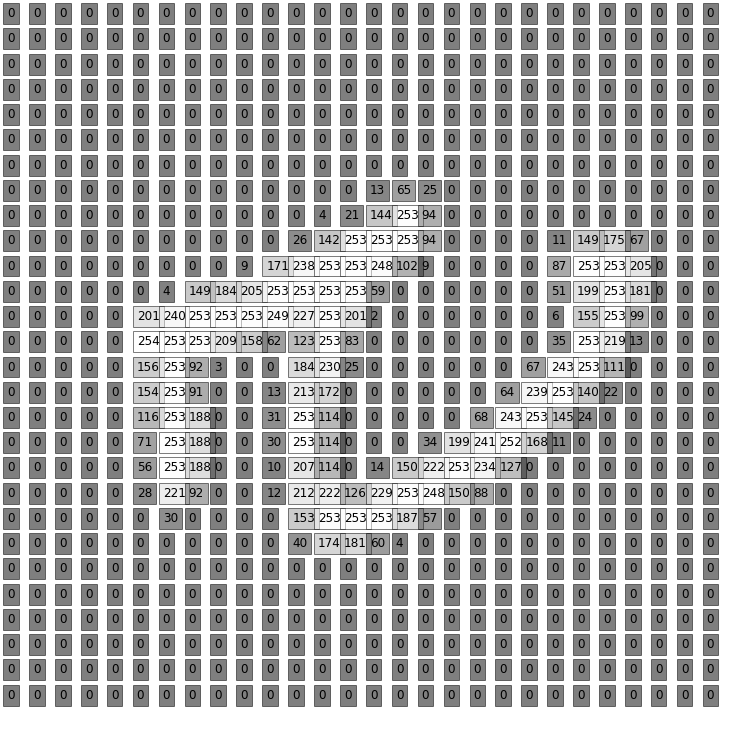

In [50]:
rand_number = random.randint(0, len(y_train))
print(y_train[rand_number])
plot_digit(X_train_plot[rand_number])

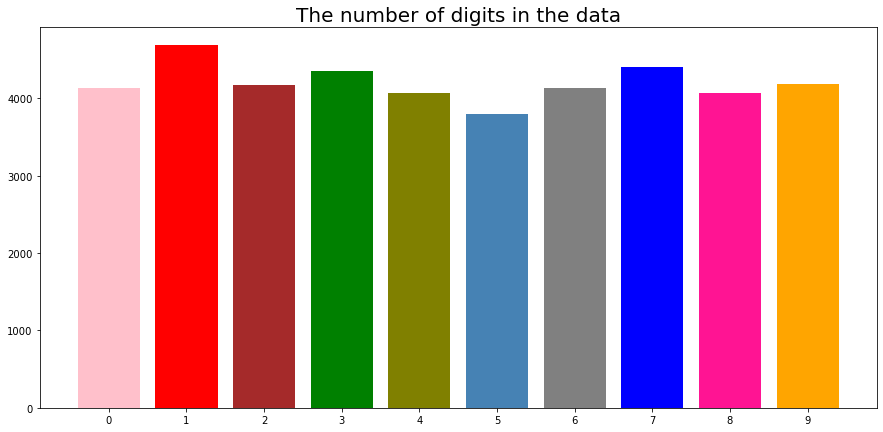

In [51]:
# chart of the number of digits in the data
digit_range = np.arange(10)

val = y_train.value_counts().index
cnt = y_train.value_counts().values
mycolors = ['red', 'blue', 'green', 'orange', 'brown', 'grey', 'pink', 'olive', 'deeppink', 'steelblue']

plt.figure(figsize = (15, 7))
plt.title("The number of digits in the data", fontsize = 20)
plt.xticks(range(10))
plt.bar(val, cnt, color = mycolors);

In [52]:
num_pixels = X_train.shape[1]

# Data normalization [0, 1]
X_train /= 255
X_test /= 255
y_train = to_categorical(y_train)

num_classes = y_train.shape[1]

print(X_train.shape, X_test.shape)

(42000, 784) (28000, 784)


In [63]:
# X_train = X_train.values.reshape(-1, 28, 28, 1)
# X_test = X_test.values.reshape(-1, 28, 28, 1)
input_shape = (28, 28, 1)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=100, stratify=y_train)

In [65]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [66]:
def draw_learning_curve(history, keys=['f1', 'loss']):
    plt.figure(figsize=(20, 8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x=history.epoch, y=history.history[key])
        sns.lineplot(x=history.epoch, y=history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='best')
    plt.show()

In [67]:
def cnn():
    Sequential()
    Conv2D(32, kernel_size=(3, 3), activation='relu',
           padding='same', input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")

    return model

In [68]:
model = cnn()
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 128)        

In [60]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_checkpoint = ModelCheckpoint("model.h5", save_best_only=True)
callbacks = [reduce_lr, early_stopping, model_checkpoint]

In [61]:
learning_history = model.fit(X_train, y_train,
          batch_size = 128,
          epochs = 10,
          verbose = 1,
          callbacks = callbacks,
          validation_data = (X_val, y_val),
          validation_split =0.2)

Epoch 1/10
101/237 [===========>..................] - ETA: 25s - loss: nan - accuracy: 0.0982

KeyboardInterrupt: 

In [17]:
loss, acc = model.evaluate(X_val, y_val, verbose=0)
print("Loss = %.2f" % loss)
print("Accuracy = %.2f" % (acc * 100.0))

Loss = 0.07
Accuracy = 97.90


KeyError: 'f1'

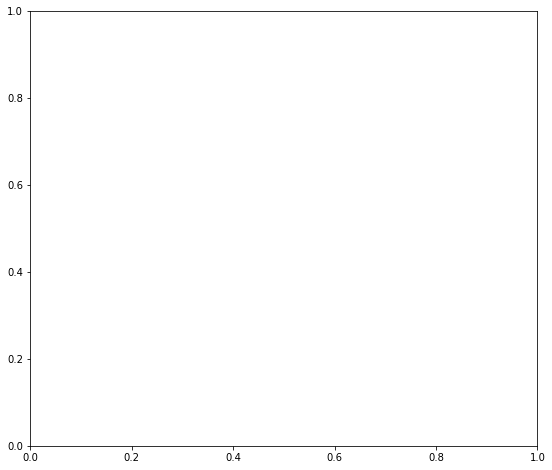

In [29]:
draw_learning_curve(learning_history)